<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Viscous flow past a circular cylinder

In this notebook, we will solve the Navier-Stokes equations for the flow past a stationary circular cylinder. Although the body is stationary and the freestream flow is constant, the flow itself will be unsteady. This is because we assume that the flow starts at rest and then suddenly turns on at t = 0. We assume that there are no walls near the body---it is called an *external flow*.

We will assume that the flow is two-dimensional. For this reason, we are relatively limited in the range of Reynolds numbers we will study: essentially, Re = 1000 is about as large as we are prepared to go.

The tools here allow you to set up a wide variety of body shapes, including airfoils, circles, rectangles, flat plates, or more abstract shapes.

### First, set up the environment

In [1]:
using MAE150A

In [2]:
pyplot()
initialize_environment()

### Solve flow past a circular cylinder

Set the flow parameters

In [3]:
Re = 500; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the grid cell spacing

In [4]:
Δx = 0.02

0.02

In [17]:
R = 0.5
body = ViscousFlow.Circle(R,100);

Transform the body with a specified initial position and orientation.

In [28]:
cent = (0.0,0.0) #1.0+1.0im
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Circular body with 100 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the domain

In [29]:
xlim = (-1.5,3.5)
ylim = (-1.0,1.0)

(-1.0, 1.0)

Plot the body in the flow domain, just to make sure it looks as expected

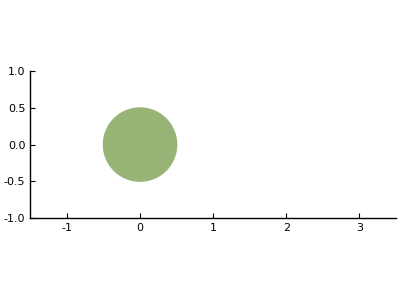

In [30]:
plot(body,xlim=xlim,ylim=ylim)

### Now set up the system

In [58]:
xf = (1.5,0.0);
Ff = 10.0;
t0 = 4.0; σ = 1.0;
wforce = PointForce(state,xf,Ff,t0,σ,sys)

Transient point force applied on the Nodes{Dual,252,104,Float64} field.
   strength = 10.0
   location = (1.5, 0.0)
   central time = 4.0
   half-interval = 1.0


In [60]:
function MAE150A.initialize_ns_solver(Re,U∞,Δx,xlim,ylim,body::Body;Δt = Nothing)
      if Δt == Nothing
          # Use CFL criteria to establish time step size
          Δt = min(0.5*Δx,0.5*Δx^2*Re)
      end
      X = VectorData(body.x,body.y)

      sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)
      state = Nodes(Dual,size(sys))
      f = VectorData(X)

      plan_intfact(t,u) = Systems.plan_intfact(t,u,sys)
      plan_constraints(u,t) = ViscousFlow.TimeMarching.plan_constraints(u,t,sys)
      r₁(u,t) = ViscousFlow.TimeMarching.r₁(u,t,sys) + wforce(t)
      r₂(u,t) = ViscousFlow.TimeMarching.r₂(u,t,sys)

      return IFHERK(state,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ViscousFlow.TimeMarching.RK31,isstored=true), sys, state, f
  end

Set up the system and solver here

In [61]:
solver, sys, state0, f = initialize_ns_solver(Re,U∞,Δx,xlim,ylim,body)

(Order-3 IF-HERK integrator with
   State of type Nodes{Dual,252,104,Float64}
   Force of type VectorData{100,Float64}
   Time step size 0.01
, Navier-Stokes system on a grid of size 252 x 104, Dual nodes in a (nx = 252, ny = 104) cell grid of type Float64 data
  Number of Dual nodes: (nx = 252, ny = 104), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Initialize the state vector

In [62]:
t = 0.0
state0 .= 0.0
state = deepcopy(state0)
nothing

### Advance the system

Set the time range to integrate over.

In [63]:
tf = 30
T = sys.Δt:sys.Δt:tf

0.01:0.01:30.0

Initialize the storage of solution data

In [64]:
# integrated force components on the body
fx = Float64[]
fy = Float64[]
thist = Float64[]

# state vector data
tmin_store = 0.0
tmax_store = 100.0
tsample = 0.1
S = StorePlan(tmin_store,tmax_store,tsample,state,f,t,htype=RegularHistory)
data_history = initialize_storage(S)
nothing

Advance the solution. This will take a few minutes, usually.

In [65]:
@time for iter in eachindex(T)
    global t, state, f = solver(t,state)
    
    store_data!(data_history,t,S,deepcopy(state),deepcopy(f),t)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    
end
println("solution completed through time t = ",t)

 93.419755 seconds (3.71 M allocations: 38.170 GiB, 7.25% gc time)
solution completed through time t = 30.00000000000189


Save the current solution data in a file

In [66]:
#save_ns_solution("CylinderFlow.jld",sys,body,state,f)

#### Plotting

In [70]:
xg, yg = coordinates(state,sys.grid)

(-1.51:0.02:3.5100000000000002, -1.03:0.02:1.03)

In [71]:
iplot = length(data_history[1]) # index of time step for plotting
u, ω, ψ, Cp = get_flowfield(data_history[1][iplot],data_history[2][iplot],sys);
nothing

Plot the vorticity field

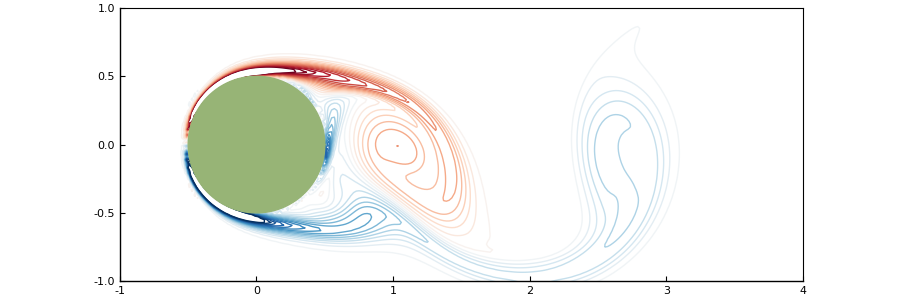

In [72]:
plot(xg,yg,ω,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15),ylim=(-1,1),xlim=(-1,4),size=(900,300))
plot!(body)

Plot the streamlines

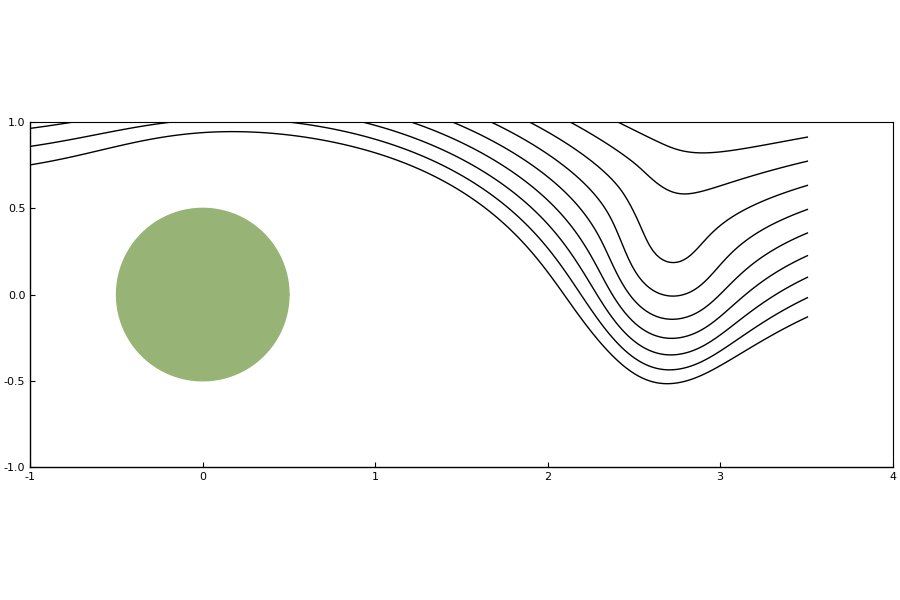

In [73]:
plot(xg,yg,ψ,levels=range(-1,2,length=31), color = :black, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(body)

Plot lift and drag coefficient

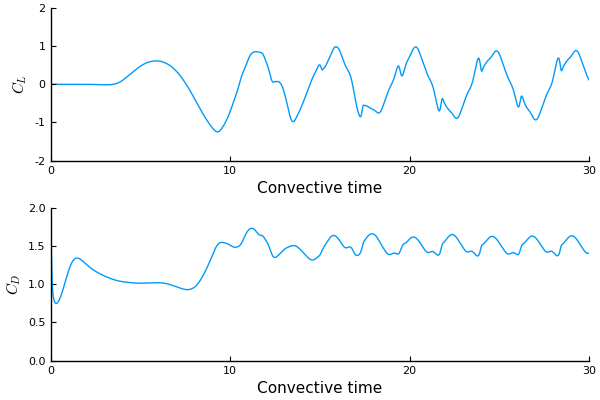

In [77]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,30),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,30),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

### Look at particle trajectories

In [ ]:
x0 = [-1.0,0]
Tmax = 5.0
Δt = 0.001
sol = compute_trajectory(u,sys,x0,Tmax,Δt);

In [ ]:
plot(sol[1,:],sol[2,:],linewidth=2,xlim=(-1,4),ylim=(-1,1))
plot!(body)